<a href="https://colab.research.google.com/github/edwin-19/ocr_exploration/blob/main/MixNetTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install mmcv
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.5/469.5 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.5/437.5 kB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 29.6 MB/s eta 0:00:00
  Created wheel for mmcv: filename=mmcv-2.0.1-cp310-cp310-linux_x86_64.whl size=27646268 sha256=7c7ac2ecb0bc5910ccdcd3250f5d11a49c2ab82baa4d6cf40805957611eeb688
  Stored in directory: /root/.cache/pip/wheels/17/58/eb/d8f23c5eb52bc7441f5b41a682a03b35277fc8cd4779d200b9
Successfully built mmcv


In [2]:
!pip install gdown
!git clone https://github.com/D641593/MixNet.git

Cloning into 'MixNet'...
remote: Enumerating objects: 2874, done.
remote: Counting objects: 100% (2874/2874), done.
remote: Compressing objects: 100% (2544/2544), done.
remote: Total 2874 (delta 102), reused 2824 (delta 71), pack-reused 0
Receiving objects: 100% (2874/2874), 13.94 MiB | 29.13 MiB/s, done.
Resolving deltas: 100% (102/102), done.


In [3]:
%cd MixNet

/content/MixNet


In [4]:
!gdown https://drive.google.com/uc?id=1TZ3mepayJZHfh9V2CffDuyXwKZPRuE8Y -O model/Totaltext_mid/
!gdown https://drive.google.com/uc?id=1bb-0-czCxfulsz4LVnTwbDKriX-KdIrz -O model/TD500HUST_mid/
!gdown https://drive.google.com/uc?id=1V86i1vPR1l96e9GQ6eZ1CWa6mOdTET8H -O model/Ctw1500/

Downloading...
From: https://drive.google.com/uc?id=1TZ3mepayJZHfh9V2CffDuyXwKZPRuE8Y
To: /content/MixNet/model/Totaltext_mid/MixNet_FSNet_M_622.pth
100% 147M/147M [00:02<00:00, 59.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bb-0-czCxfulsz4LVnTwbDKriX-KdIrz
To: /content/MixNet/model/TD500HUST_mid/MixNet_FSNet_M_284.pth
100% 147M/147M [00:02<00:00, 49.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1V86i1vPR1l96e9GQ6eZ1CWa6mOdTET8H
To: /content/MixNet/model/Ctw1500/MixNet_FSNet_hor_925.pth
100% 189M/189M [00:01<00:00, 96.1MB/s]


In [5]:
from datasets import load_dataset
dataset = load_dataset("TrainingDataPro/ocr-text-detection-in-the-documents")

Resolving data files:   0%|          | 0/33 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [8]:
import os
import time
import cv2
import numpy as np
import json
from shapely.geometry import *
import torch
import subprocess
import torch.backends.cudnn as cudnn
import torch.utils.data as data
from dataset import TotalText
from network.textnet import TextNet
from cfglib.config import config as cfg, update_config, print_config
from cfglib.option import BaseOptions
from util.augmentation import BaseTransform
from util.visualize import visualize_detection, visualize_gt
from util.misc import to_device, mkdirs,rescale_result, get_cosine_map

In [129]:
cfg['net'] = 'FSNet_M'
cfg['exp_name'] = 'Totaltext_mid'
cfg['scale'] = 1
cfg['checkepoch'] = 622
cfg['test_size'] = 640, 1024
cfg['dis_threshold'] = 0.7
cfg['cls_threshold'] = 0.85
cfg['mid'] = True
cfg['resume'] = None
cfg['embed'] = False
cfg['onlybackbone'] = False
cfg['save_dir'] = './model'
cfg['device'] = 'cpu'
cfg['vis_dir'] = 'vis'

In [130]:
model = TextNet(is_training=False, backbone=cfg.net)
model_path = os.path.join(cfg.save_dir, cfg.exp_name,'MixNet_{}_{}.pth'.format(model.backbone_name, cfg.checkepoch))
model.load_model(model_path)
model.to(cfg.device)  # copy to cuda
model.eval();

MixNet backbone parameter size:  29339968
Loading from ./model/Totaltext_mid/MixNet_FSNet_M_622.pth


In [131]:
from util.augmentation import Augmentation
from util import canvas as cav

In [132]:
transform = BaseTransform(size=cfg.test_size, mean=cfg.means, std=cfg.stds)

In [133]:
img = np.array(dataset['train'][4]['image'].convert('RGB'))

In [134]:
H, W, _ = img.shape
image_transform, polygon = transform(img)
image_transform = image_transform.transpose(2, 0, 1)

In [135]:
input_dict = {
    'img': torch.from_numpy(image_transform).unsqueeze(0)
}
# get detection result
with torch.no_grad():
    output_dict = model(input_dict)

In [136]:
def visualize_detection(image, output_dict, meta=None):
    image_show = image.copy()
    image_show = np.ascontiguousarray(image_show[:, :, ::-1])

    cls_preds = torch.nn.functional.interpolate(output_dict["fy_preds"], scale_factor=cfg.scale, mode='bilinear')
    cls_preds = cls_preds[0].data.cpu().numpy()

    py_preds = output_dict["py_preds"][1:]
    init_polys = output_dict["py_preds"][0]
    shows = []

    if cfg.mid:
        midline = output_dict["midline"]

    init_py = init_polys.data.cpu().numpy()
    path = os.path.join(cfg.vis_dir, '{}_test'.format(cfg.exp_name),
                        meta['image_id'][0].split(".")[0] + "_init.png")

    im_show0 = image_show.copy()
    for i, bpts in enumerate(init_py.astype(np.int32)):
        cv2.drawContours(im_show0, [bpts.astype(np.int32)], -1, (255, 0, 255), 2)
        for j, pp in enumerate(bpts):
            if j == 0:
                cv2.circle(im_show0, (int(pp[0]), int(pp[1])), 3, (125, 125, 255), -1)
            elif j == 1:
                cv2.circle(im_show0, (int(pp[0]), int(pp[1])), 3, (125, 255, 125), -1)
            else:
                cv2.circle(im_show0, (int(pp[0]), int(pp[1])), 3, (255, 125, 125), -1)

    cv2.imwrite(path, im_show0)

    for idx, py in enumerate(py_preds):
        im_show = im_show0.copy()
        contours = py.data.cpu().numpy()
        cv2.drawContours(im_show, contours.astype(np.int32), -1, (0, 255, 255), 2)
        for ppts in contours:
            for j, pp in enumerate(ppts):
                if j == 0:
                    cv2.circle(im_show, (int(pp[0]), int(pp[1])), 3, (125, 125, 255), -1)
                elif j == 1:
                    cv2.circle(im_show, (int(pp[0]), int(pp[1])), 3, (125, 255, 125), -1)
                else:
                    cv2.circle(im_show, (int(pp[0]), int(pp[1])), 3, (255, 125, 125), -1)
        if cfg.mid:
            for ppt in midline:
                for pt in ppt:
                    cv2.circle(im_show, (int(pt[0][0]), int(pt[0][1])), 3, (255, 0, 0), -1)

        path = os.path.join(cfg.vis_dir, '{}_test'.format(cfg.exp_name),
                             meta['image_id'][0].split(".")[0] + "_{}iter.png".format(idx))
        cv2.imwrite(path, im_show)
        shows.append(im_show)

    show_img = np.concatenate(shows, axis=1)
    show_boundary = cv2.resize(show_img, (320 * len(py_preds), 320))

    cls_pred = cav.heatmap(np.array(cls_preds[0] * 255, dtype=np.uint8))
    dis_pred = cav.heatmap(np.array(cls_preds[1] * 255, dtype=np.uint8))

    heat_map = np.concatenate([cls_pred*255, dis_pred*255], axis=1)
    heat_map = cv2.resize(heat_map, (320 * 2, 320))

    return show_boundary, heat_map
meta = {
    'image_id': ['sample.png']
}
show_boundary, heat_map = visualize_detection(img, output_dict, meta=meta)

True

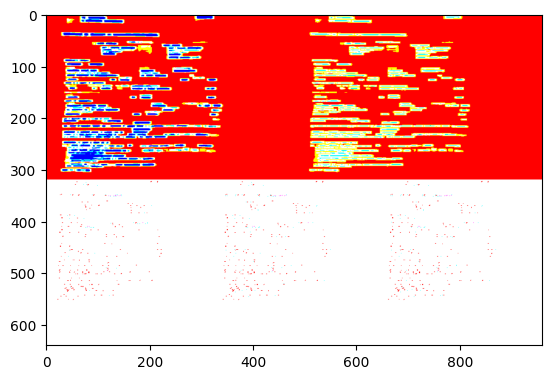

In [137]:
%matplotlib inline

from matplotlib import pyplot as plt
show_map = np.concatenate([heat_map], axis=1)
show_map = cv2.resize(show_map, (320 * 3, 320))
im_vis = np.concatenate([show_map, show_boundary], axis=0)
plt.imshow(im_vis)
cv2.imwrite('../test.jpg', im_vis)

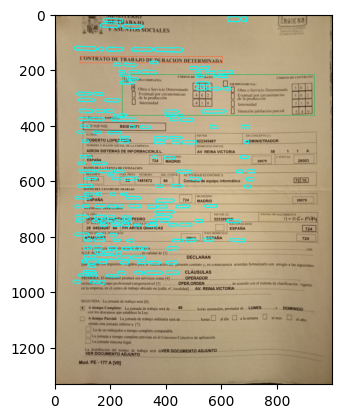

In [138]:
%matplotlib inline
py_preds = output_dict["py_preds"][1:]
new_img = img.copy()
for idx, py in enumerate(py_preds):
  contours = py.data.cpu().numpy()
  cv2.drawContours(new_img, contours.astype(np.int32), -1, (0, 255, 255), 2)

plt.imshow(new_img)
plt.show()